In [1]:
import sys
import os

# Add parent directory to path to access modules
sys.path.insert(0, os.path.abspath('..'))

import xarray as xr
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from esda.moran import Moran
from eval.metrics import *
from eval.plot import *
import data.valid_crd as valid_crd
import yaml
import data.helper as helper
from matplotlib.colors import ListedColormap
import math
import scipy.stats as stats
# import statsmodels.api as sm
from collections import defaultdict
from scipy.stats import gaussian_kde

In [16]:
test_period = [1990, 2014]
spatial_extent = [1, 13]


# exps = ['7b47e6bb', '154cc61f', '2534f721', 'ff8e2b31', '24043f2e', '82e3636f'] #AdamW, LOCAspatio_tempConv1d, harmonic3, spatialCorrloss monotone2-8, lr1e-4, livneh
# testep = [120, 100, 50, 110, 10, 150]

exps = ['e814b898', '8deb3ef7', '6461ac40', '33a08a0d', 'f9b1bafc', 'e2f7a0c3'] #AdamW, LOCAspatio_tempLSTM, harmonic3, spatialCorrloss monotone2-8, lr1e-4, livneh
testep = [70, 150, 10, 120, 160, 100]



save_path = '/pscratch/sd/k/kas7897/dCLIMAD_BA/plots/Spatial(1,13)AdamW, LOCAspatio_tempLSTM, harmonic3, spatialCorrloss montone2-8, lr1e-4, livneh/'
os.makedirs(save_path, exist_ok=True)

def load_model_run(run_id, test_period, epoch=None, base_dir='/pscratch/sd/k/kas7897/dCLIMAD_BA/outputs/spatial_AdamW_harmonic2/jobs_LOCAspatioTempLSTM'):
    run_path = helper.load_run_path(run_id, base_dir)

    flat_dir = os.path.join(run_path, f"{test_period[0]}_{test_period[1]}")

    future_path = os.path.join(run_path, "ssp5_8_5_2075_2099")

    # Check which structure exists
    data_path = flat_dir
    config_path = os.path.join(run_path, 'train_config.yaml')

    x = torch.load(os.path.join(data_path, 'x.pt'), map_location='cpu', weights_only=True).squeeze(-1).numpy()
    x[x<0.254] = 0
    y = torch.load(os.path.join(data_path, 'y.pt'), map_location='cpu', weights_only=True).squeeze(-1).numpy()
    y[y<0.254] = 0
    time = torch.load(os.path.join(data_path, 'time.pt'), map_location='cpu', weights_only=False)

    xt = None
    if epoch is not None:
        xt_path = os.path.join(data_path, f'ep{epoch}', 'xt.pt')
        if os.path.exists(xt_path):
            xt = torch.load(xt_path, map_location='cpu', weights_only=False)
        else:
            print(run_id)
        xt[xt<0.254] = 0

    
    future_x= None; future_xt = None; future_time = None
    # future_x = torch.load(os.path.join(future_path, 'x.pt'), map_location='cpu').squeeze(-1).numpy()
    # future_x[future_x<0.254] = 0 
    # y = torch.load(os.path.join(future_path, 'y.pt'), map_location='cpu').squeeze(-1).numpy()
    # y[y<0.254] = 0
    # future_time = torch.load(os.path.join(future_path, 'time.pt'), map_location='cpu')

    
    # future_xt = torch.load(os.path.join(future_path, 'xt.pt'), map_location='cpu')
    # future_xt[future_xt<0.254] = 0

    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    return {
        'run_path': run_path,
        'x': x,
        'y': y,
        'time': time,
        'xt': xt,
        'future_x': future_x,
        'future_xt': future_xt,
        'future_time': future_time,
        'config': config
    }

models = []
for i in range(len(exps)):
    model = load_model_run(exps[i], test_period, epoch=testep[i])
    models.append(model)

In [17]:
valid_coords = []
# loca_all = []
# QM_all = []
# ISIMIP_all = []
# ECDFM_all = []
# LS_all = []
# QDM_all = []
# # DC_all = []
# SDM_all = []


# loca_future_all = []
# QM_future_all = []

for i in range(len(models)):
    
    cmip6_dir = models[i]['config']['cmip_dir']
    clim = models[i]['config']['clim']
    ref = models[i]['config']['ref']
    train_period = [models[i]['config']['train_start'], models[i]['config']['train_end']]
    future_period = [2015,2099]


    ds_sample = xr.open_dataset(f"{cmip6_dir}/{clim}/historical/precipitation/clipped_US.nc")

    shapefile_path = None if not  models[i]['config']['spatial_test']  else models[i]['config']['shapefile_filter_path']
    
    valid_coords.append(valid_crd.valid_lat_lon(ds_sample, var_name='pr', shapefile_path=shapefile_path, attrList=spatial_extent))

In [18]:
## this block filters 'y' based on 'x' calender
counter = 0
for model in models:
    time = model['time']
    
    x_time_np = np.array([pd.Timestamp(str(t)) for t in time])
    x_time_np = np.array([pd.Timestamp(t).replace(hour=0, minute=0, second=0) for t in x_time_np], dtype='datetime64[D]')
    # Generate a daily time array following the standard Gregorian calendar
    y_time = pd.date_range(start=f"{test_period[0]}-01-01", end=f"{test_period[1]}-12-31", freq="D")

    # Convert to NumPy array for indexing and comparison
    y_time_np = y_time.to_numpy()

    # Find indices where observed time matches model time
    matched_indices = np.where(np.isin(y_time_np, x_time_np))[0]

    model['y'] = model['y'][matched_indices,:]
    model['x_time_np'] = x_time_np

    # loca_all[counter] = loca_all[counter][matched_indices, :]

    # future_time = model['future_time']

    # future_period = [model['config']['trend_start'], model['config']['trend_end']]

    # future_x_time = np.array([pd.Timestamp(str(t)) for t in future_time])
    # future_x_time = np.array([pd.Timestamp(t).replace(hour=0, minute=0, second=0) for t in future_x_time], dtype='datetime64[D]')

    # future_all_time = pd.date_range(start=f"{future_period[0]}-01-01", end=f"{future_period[1]}-12-31", freq="D")
    # future_all_time_np = future_all_time.to_numpy()

    # future_matched_indices = np.where(np.isin(future_all_time_np, future_x_time))[0]

    # loca_future_all[counter] = loca_future_all[counter][future_matched_indices, :]

    # model['future_time'] = future_x_time

    counter+=1

# ref_eval_data = models[exps.index(ref_eval)]['y']






In [19]:
def find_nearest_indices(city_coords, valid_coords):
    nearest_indices = []
    nearest_coords = []

    for coord in city_coords:
        # Broadcasting subtraction
        dists = np.linalg.norm(valid_coords - coord, axis=1)
        idx = np.argmin(dists)
        nearest_indices.append(idx)
        nearest_coords.append(valid_coords[idx])

    return nearest_indices, np.array(nearest_coords)


interp_coords = []
ensemble_coords = valid_coords[2]
for coords in valid_coords:
    interp_coords.append(find_nearest_indices(ensemble_coords, coords))

In [20]:


# Initialize climate indices manager
climate_indices = ClimateIndices()

thresholds = climate_indices.get_indices()

x_ensemble_indices = {}
# y_ensemble_indices = {}
xt_ensemble_indices = {}
# loca_ensemble_indices = {}
# QM_ensemble_indices = {}
# ISIMIP_ensemble_indices = {}
# SDM_ensemble_indices = {}
# ECDFM_ensemble_indices = {}
# LS_ensemble_indices = {}
# QDM_ensemble_indices = {}
# SDM_ensemble_indices = {}

counter = 0 
for model in models:

    for label, (threshold, comparison) in thresholds.items():
        if callable(threshold):  # If function, apply it to y
            model[f'{label}_x'] = threshold(model['x_time_np'], model['x'])
            model[f'{label}_y'] = threshold(model['x_time_np'], model['y'])
            model[f'{label}_xt'] = threshold(model['x_time_np'], model['xt'])
            # model[f'{label}_loca'] = threshold(model['x_time_np'], loca_all[counter])
            # model[f'{label}_QM'] = threshold(model['x_time_np'], QM_all[counter])
            # model[f'{label}_ISIMIP'] = threshold(model['x_time_np'], ISIMIP_all[counter])
            # model[f'{label}_ECDFM'] = threshold(model['x_time_np'], ECDFM_all[counter])
            # model[f'{label}_SDM'] = threshold(model['x_time_np'], SDM_all[counter])
            # model[f'{label}_LS'] = threshold(model['x_time_np'], LS_all[counter])
            # model[f'{label}_QDM'] = threshold(model['x_time_np'], QDM_all[counter])

            if label not in x_ensemble_indices:
                x_ensemble_indices[label] = model[f'{label}_x'][:, interp_coords[counter][0]]/len(models)
                # y_ensemble_indices[label] = model[f'{label}_y'][:, interp_coords[counter][0]]
                xt_ensemble_indices[label] = model[f'{label}_xt'][:, interp_coords[counter][0]]/len(models)
                # loca_ensemble_indices[label] = model[f'{label}_loca'][:, interp_coords[counter][0]]/len(models)
                # QM_ensemble_indices[label] = model[f'{label}_QM'][:, interp_coords[counter][0]]/len(models)
                # ISIMIP_ensemble_indices[label] = model[f'{label}_ISIMIP'][:, interp_coords[counter][0]]/len(models)
                # ECDFM_ensemble_indices[label] = model[f'{label}_ECDFM'][:, interp_coords[counter][0]]/len(models)
                # LS_ensemble_indices[label] = model[f'{label}_LS'][:, interp_coords[counter][0]]/len(models)
                # QDM_ensemble_indices[label] = model[f'{label}_QDM'][:, interp_coords[counter][0]]/len(models)
                # SDM_ensemble_indices[label] = model[f'{label}_SDM'][:, interp_coords[counter][0]]/len(models)
            else:
                x_ensemble_indices[label]+= model[f'{label}_x'][:, interp_coords[counter][0]]/len(models)
                xt_ensemble_indices[label]+= model[f'{label}_xt'][:, interp_coords[counter][0]]/len(models)
                # loca_ensemble_indices[label]+= model[f'{label}_loca'][:, interp_coords[counter][0]]/len(models)
                # QM_ensemble_indices[label]+= model[f'{label}_QM'][:, interp_coords[counter][0]]/len(models)
                # ISIMIP_ensemble_indices[label]+= model[f'{label}_ISIMIP'][:, interp_coords[counter][0]]/len(models)
                # ECDFM_ensemble_indices[label]+= model[f'{label}_ECDFM'][:, interp_coords[counter][0]]/len(models)
                # LS_ensemble_indices[label]+= model[f'{label}_LS'][:, interp_coords[counter][0]]/len(models)
                # QDM_ensemble_indices[label]+= model[f'{label}_QDM'][:, interp_coords[counter][0]]/len(models)
                # SDM_ensemble_indices[label]+= model[f'{label}_SDM'][:, interp_coords[counter][0]]/len(models)
    counter+=1
    

In [21]:
bias_dict = {}

for label, (threshold, comparison) in thresholds.items():
    y_ensemble_indices = models[2]
    if callable(threshold):
        xt_bias = compute_mean_bias_percentage(None, x_ensemble_indices[label], y_ensemble_indices[f'{label}_y'], xt_ensemble_indices[label])
        # loca_bias = compute_mean_bias_percentage(None, x_ensemble_indices[label], y_ensemble_indices[f'{label}_y'], loca_ensemble_indices[label])
        # QM_bias = compute_mean_bias_percentage(None, x_ensemble_indices[label], y_ensemble_indices[f'{label}_y'], QM_ensemble_indices[label])
        # ISIMIP_bias = compute_mean_bias_percentage(None, x_ensemble_indices[label], y_ensemble_indices[f'{label}_y'], ISIMIP_ensemble_indices[label])
        # ECDFM_bias = compute_mean_bias_percentage(None, x_ensemble_indices[label], y_ensemble_indices[f'{label}_y'], ECDFM_ensemble_indices[label])
        # LS_bias = compute_mean_bias_percentage(None, x_ensemble_indices[label], y_ensemble_indices[f'{label}_y'], LS_ensemble_indices[label])
        # QDM_bias = compute_mean_bias_percentage(None, x_ensemble_indices[label], y_ensemble_indices[f'{label}_y'], QDM_ensemble_indices[label])
        # SDM_bias = compute_mean_bias_percentage(None, x_ensemble_indices[label], y_ensemble_indices[f'{label}_y'], SDM_ensemble_indices[label])

        # bias_dict[label] = (xt_bias[0], xt_bias[1], QM_bias[1], ISIMIP_bias[1], ECDFM_bias[1], LS_bias[1], QDM_bias[1], SDM_bias[1], loca_bias[1])
        bias_dict[label] = (xt_bias[0], xt_bias[1])

## add another key to the bias dict, which is average of all the previous keys for xt, loca and QM
x_avg = np.nanmean([bias[0] for bias in bias_dict.values()], axis=0)
xt_avg = np.nanmean([bias[1] for bias in bias_dict.values()], axis=0)
# QM_avg = np.nanmean([bias[2] for bias in bias_dict.values()], axis=0)
# ISIMIP_avg = np.nanmean([bias[3] for bias in bias_dict.values()], axis=0)
# ECDFM_avg = np.nanmean([bias[4] for bias in bias_dict.values()], axis=0)
# LS_avg = np.nanmean([bias[5] for bias in bias_dict.values()], axis=0)
# QDM_avg = np.nanmean([bias[6] for bias in bias_dict.values()], axis=0)
# SDM_avg = np.nanmean([bias[7] for bias in bias_dict.values()], axis=0)
# loca_avg = np.nanmean([bias[8] for bias in bias_dict.values()], axis=0)

# bias_dict['Average'] = (x_avg, xt_avg,  QM_avg, ISIMIP_avg, ECDFM_avg, LS_avg, QDM_avg, SDM_avg, loca_avg)
bias_dict['Average'] = (x_avg, xt_avg)

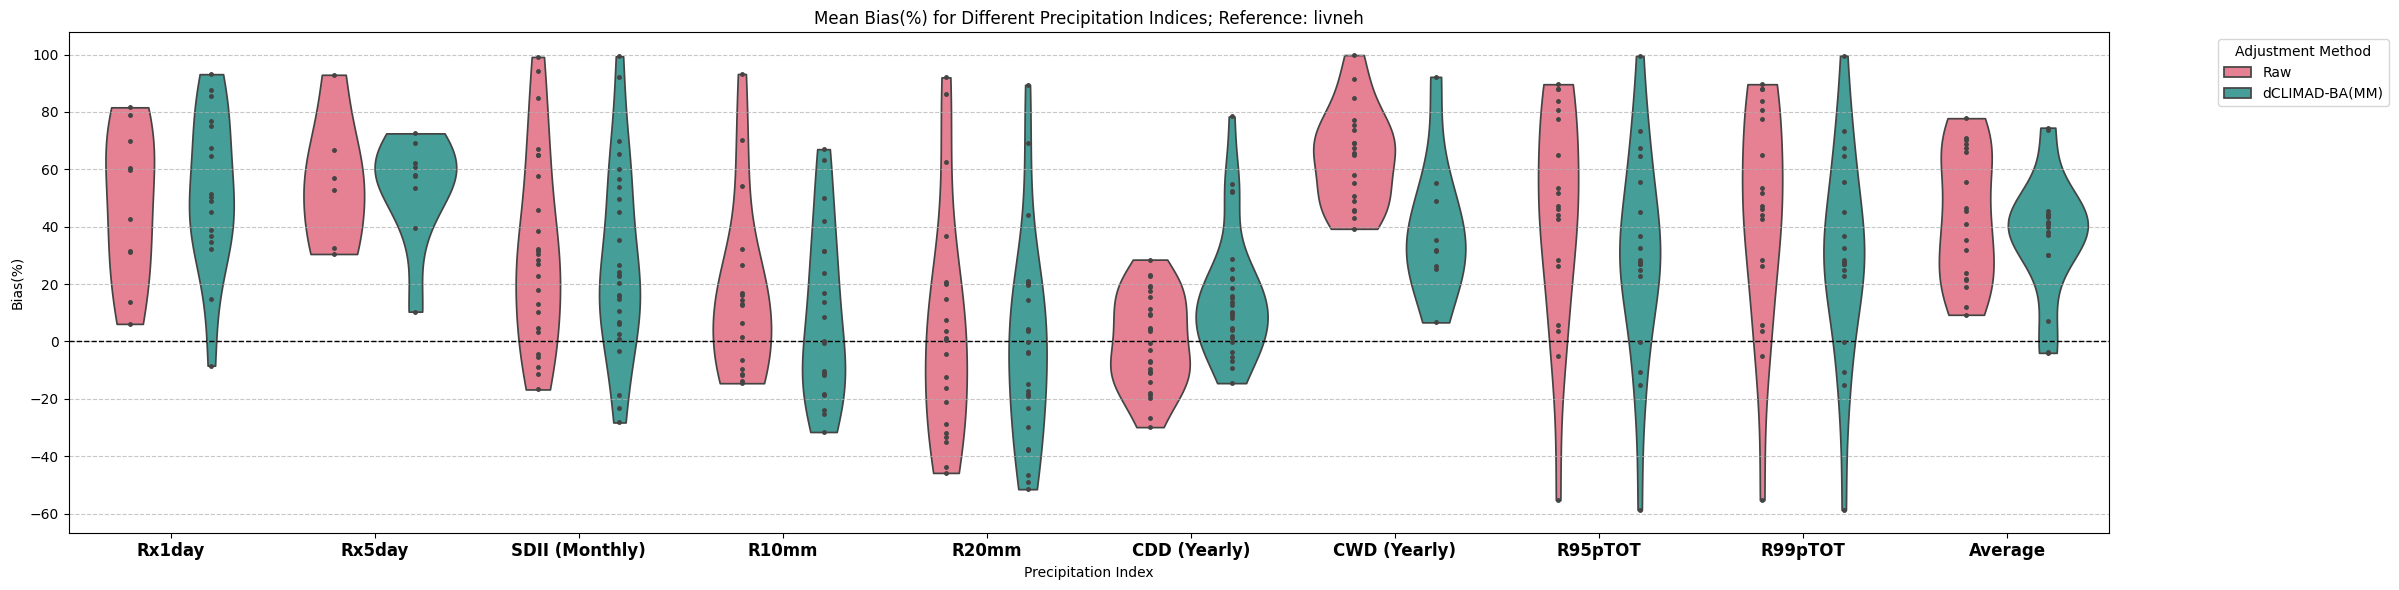

In [22]:
keys = ['SDII (Monthly)','CDD (Yearly)', 'CWD (Yearly)', "Rx1day", "Rx5day", "R10mm",  "R20mm", "R95pTOT", "R99pTOT", 'Average']
d = dict(filter(lambda item: item[0] in keys , bias_dict.items()))



# Create a 2x2 subplot figure
fig, axes = plt.subplots(1, 1, figsize=(24, 6), sharey=True)


ref_label = models[0]['config']['ref']
# method_names = ['dCLIMAD-BA(MM)','Quantile Mapping (MM)', 'ISIMIP(MM)', 'ECDFM(MM)', 'Linear Scaling(MM)', 
#                 'Quantile Delta Mapping (MM)', 'Scaled Distribution Mapping (MM)', 'LOCA(MM)', ]
method_names = ['dCLIMAD-BA(MM)'] 
# Call the function for each dataset
plot_violin_bias(axes, d, "Bias(%)", f"Mean Bias(%) for Different Precipitation Indices; Reference: {ref_label}",  method_names=method_names, remove_outlier=True)

# plot_violin_bias(axes[1], d4, "Bias(%)", "Day Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)
# fig.suptitle(f'Ensemble-Livneh', fontsize=20, fontweight="bold", y=1.02)


plt.tight_layout()
plt.savefig(f'{save_path}violin_Pindices.png')

plt.show()

In [31]:
cities = {
    # HUC 01 (New England, north → south)
    "Bangor, Maine":            [44.8011, -68.7778],
    "Concord, New Hampshire":   [43.2070, -71.5371],
    "New Bedford, Massachusetts":[41.6362, -70.9342],

    # HUC 13 (Rio Grande, north → south)
    "Alamosa, Colorado":        [37.4694, -105.8700],
    "Albuquerque, New Mexico":  [35.0844, -106.6504],
    "McAllen, Texas":           [26.2034, -98.2300],
}

# Convert to array
city_names = list(cities.keys())
city_coords = np.array(list(cities.values()))  # shape (10, 2)

# Assuming valid_coords is already loaded as a numpy array (lat, lon)
# Compute distances between each city and all valid_coords
def find_nearest_indices(city_coords, valid_coords):
    nearest_indices = []
    nearest_coords = []

    for coord in city_coords:
        # Broadcasting subtraction
        dists = np.linalg.norm(valid_coords - coord, axis=1)
        idx = np.argmin(dists)
        nearest_indices.append(idx)
        nearest_coords.append(valid_coords[idx])

    return nearest_indices, np.array(nearest_coords)

# Call the function
city_index = []
for coords in valid_coords:
    city_index.append(find_nearest_indices(city_coords, coords))

In [32]:
quantiles = np.arange(0.01, 1.00, 0.01)

quantile_x_local = []
quantile_xt_local = []
quantile_y_local = []
# quantile_loca_local = []
# quantile_QM_local = []
# quantile_ISIMIP_local = []
# quantile_ECDFM_local = []
# quantile_LS_local = []
# quantile_QDM_local = []
# quantile_SDM_local = []

for i in range(len(cities)):
    quantile_total_x = []
    quantile_total_y = []
    quantile_total_xt = []
    # quantile_total_loca = []
    # quantile_total_QM = []
    # quantile_total_ISIMIP = []
    # quantile_total_ECDFM = []
    # quantile_total_LS = []
    # quantile_total_QDM = []
    # # quantile_total_DC = []
    # quantile_total_SDM = []

    for j in range(len(models)):
        loc = city_index[j][0][i]

        quantile_total_x.append(np.nanquantile(models[j]['x'], quantiles, axis=0)[:,loc])
        quantile_total_y.append(np.nanquantile(models[j]['y'], quantiles, axis=0)[:,loc])
        quantile_total_xt.append(np.nanquantile(models[j]['xt'], quantiles, axis=0)[:,loc])
        # quantile_total_loca.append(np.nanquantile(loca_all[j], quantiles, axis=0)[:,loc])
        # quantile_total_QM.append(np.nanquantile(QM_all[j], quantiles, axis=0)[:,loc])

        # quantile_total_ISIMIP.append(np.nanquantile(ISIMIP_all[j], quantiles, axis=0)[:,loc])
        # quantile_total_ECDFM.append(np.nanquantile(ECDFM_all[j], quantiles, axis=0)[:,loc])
        # quantile_total_LS.append(np.nanquantile(LS_all[j], quantiles, axis=0)[:,loc])
        # quantile_total_QDM.append(np.nanquantile(QDM_all[j], quantiles, axis=0)[:,loc])
        # # quantile_total_DC.append(np.nanquantile(DC_all[j], quantiles, axis=0)[:,loc])
        # quantile_total_SDM.append(np.nanquantile(SDM_all[j], quantiles, axis=0)[:,loc])

    quantile_x_local.append(np.array(quantile_total_x).T)
    quantile_xt_local.append(np.array(quantile_total_xt).T)
    quantile_y_local.append(np.array(quantile_total_y).T)
    # quantile_loca_local.append(np.array(quantile_total_loca).T)
    # quantile_QM_local.append(np.array(quantile_total_QM).T)

    # quantile_ISIMIP_local.append(np.array(quantile_total_ISIMIP).T)
    # quantile_ECDFM_local.append(np.array(quantile_total_ECDFM).T)
    # quantile_LS_local.append(np.array(quantile_total_LS).T)
    # quantile_QDM_local.append(np.array(quantile_total_QDM).T)
    # quantile_SDM_local.append(np.array(quantile_total_SDM).T)

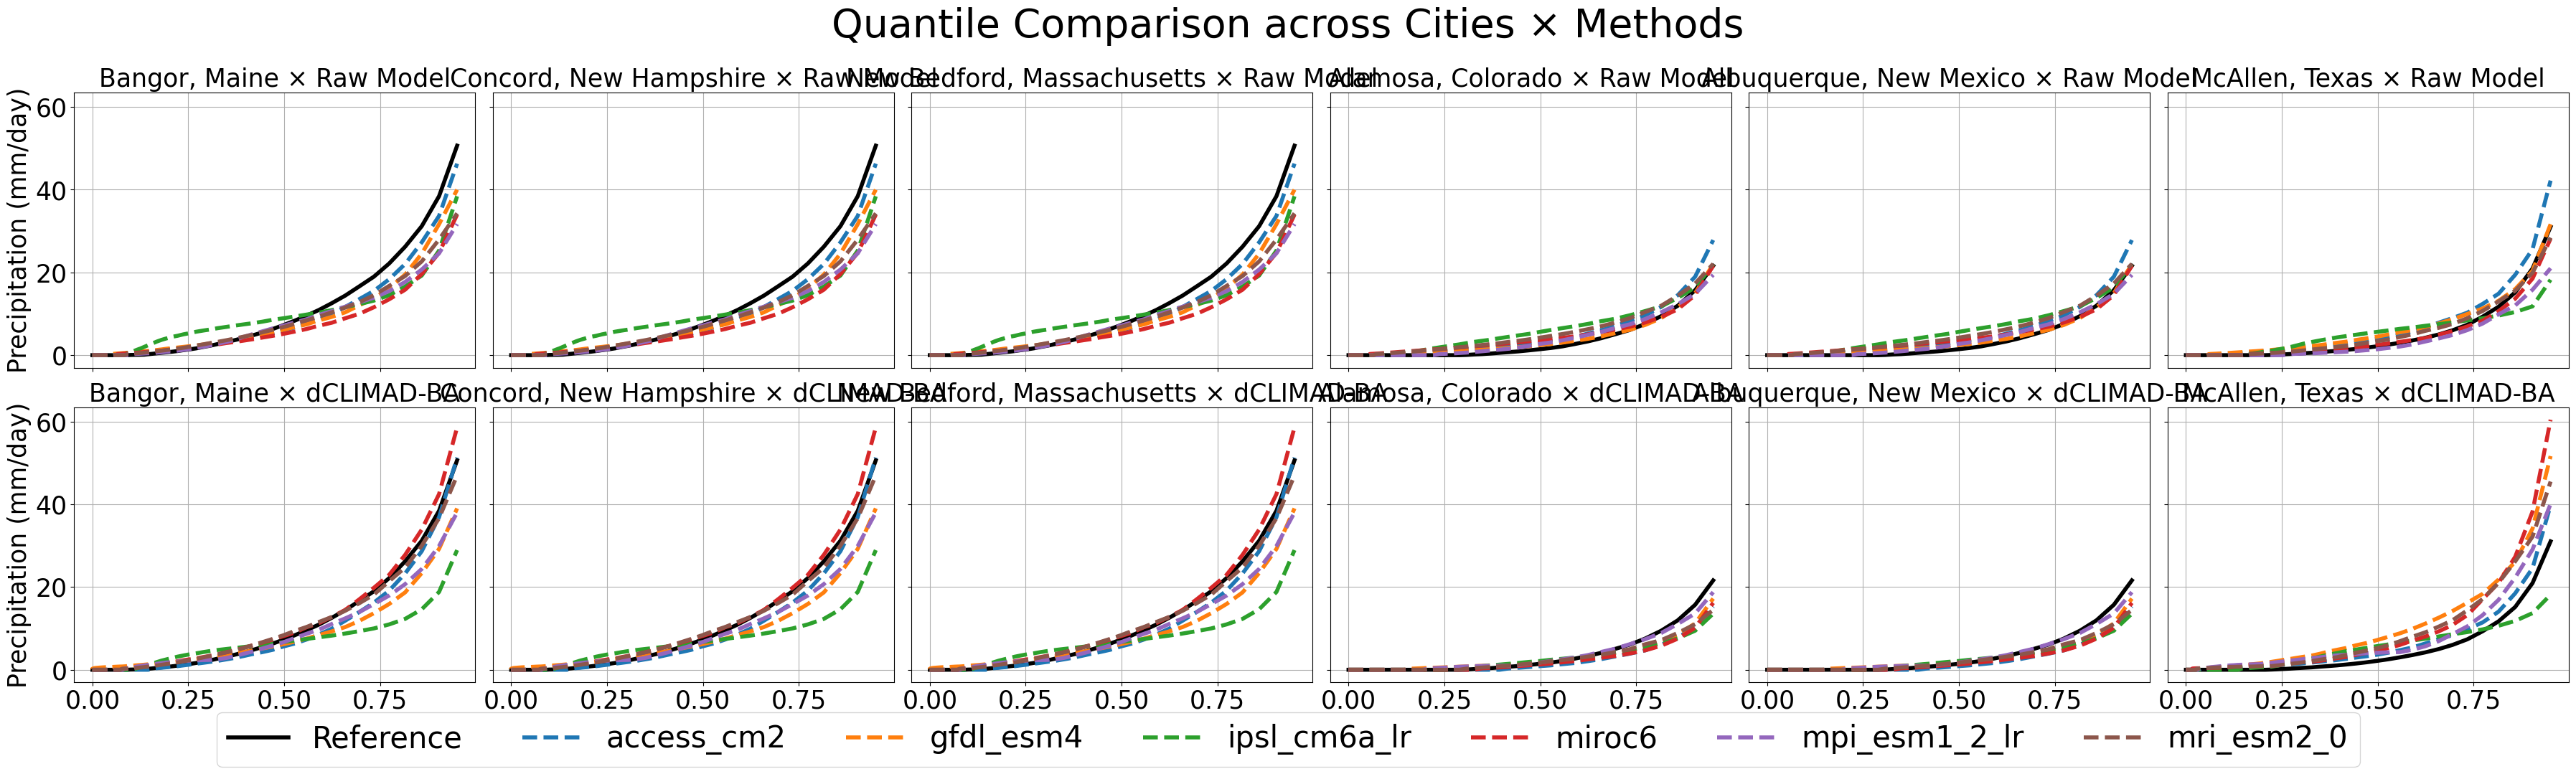

In [33]:
cmip6_models = ['access_cm2', 'gfdl_esm4', 'ipsl_cm6a_lr', 'miroc6', 'mpi_esm1_2_lr','mri_esm2_0']
city_names = list(cities.keys())
methods = {
    "Raw Model": quantile_x_local,
    "dCLIMAD-BA": quantile_xt_local,
}

n_cities = len(city_names)
n_methods = len(methods)

fig, axes = plt.subplots(
    ncols=n_cities, nrows=n_methods,
    figsize=(6*n_cities, 5*n_methods),
    sharex=True, sharey=True
)

if n_cities == 1 and n_methods == 1:
    axes = [[axes]]
elif n_cities == 1:
    axes = [axes]
elif n_methods == 1:
    axes = [[ax] for ax in axes]

for i, city in enumerate(city_names):
    for j, (method_name, method_data) in enumerate(methods.items()):
        ax = axes[j][i]

        # Plot observed (thick black)
        ax.plot(
            quantiles**5,
            quantile_y_local[i].mean(axis=1),  # mean across models (can remove if not wanted)
            color="black", linewidth=4, label="Reference"
        )

        # Plot each CMIP6 model
        n_models = method_data[i].shape[1]
        for m in range(n_models):
            ax.plot(
                quantiles**5,
                method_data[i][:, m],
                linestyle="--", linewidth=4,
                label=cmip6_models[m] if (i == 0 and j == 0) else None
            )

        ax.set_title(f"{city} × {method_name}", fontsize=25)
        if j == n_cities - 1:
            ax.set_xlabel("Warped Quantiles (power 2)", fontsize=25)
        if i == 0:
            ax.set_ylabel("Precipitation (mm/day)", fontsize=25)
        ax.grid(True)
        ax.tick_params(axis='x', labelsize=25)
        ax.tick_params(axis='y', labelsize=25)

# Global legend at bottom
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center", ncol=7,
    bbox_to_anchor=(0.5, -0.08), fontsize=30
)

fig.suptitle("Quantile Comparison across Cities × Methods", fontsize=40, y=1)
plt.tight_layout()
plt.savefig(f"{save_path}/Quantile_Comparison_Cities_x_Methods.png", bbox_inches='tight', dpi=300)
plt.show()


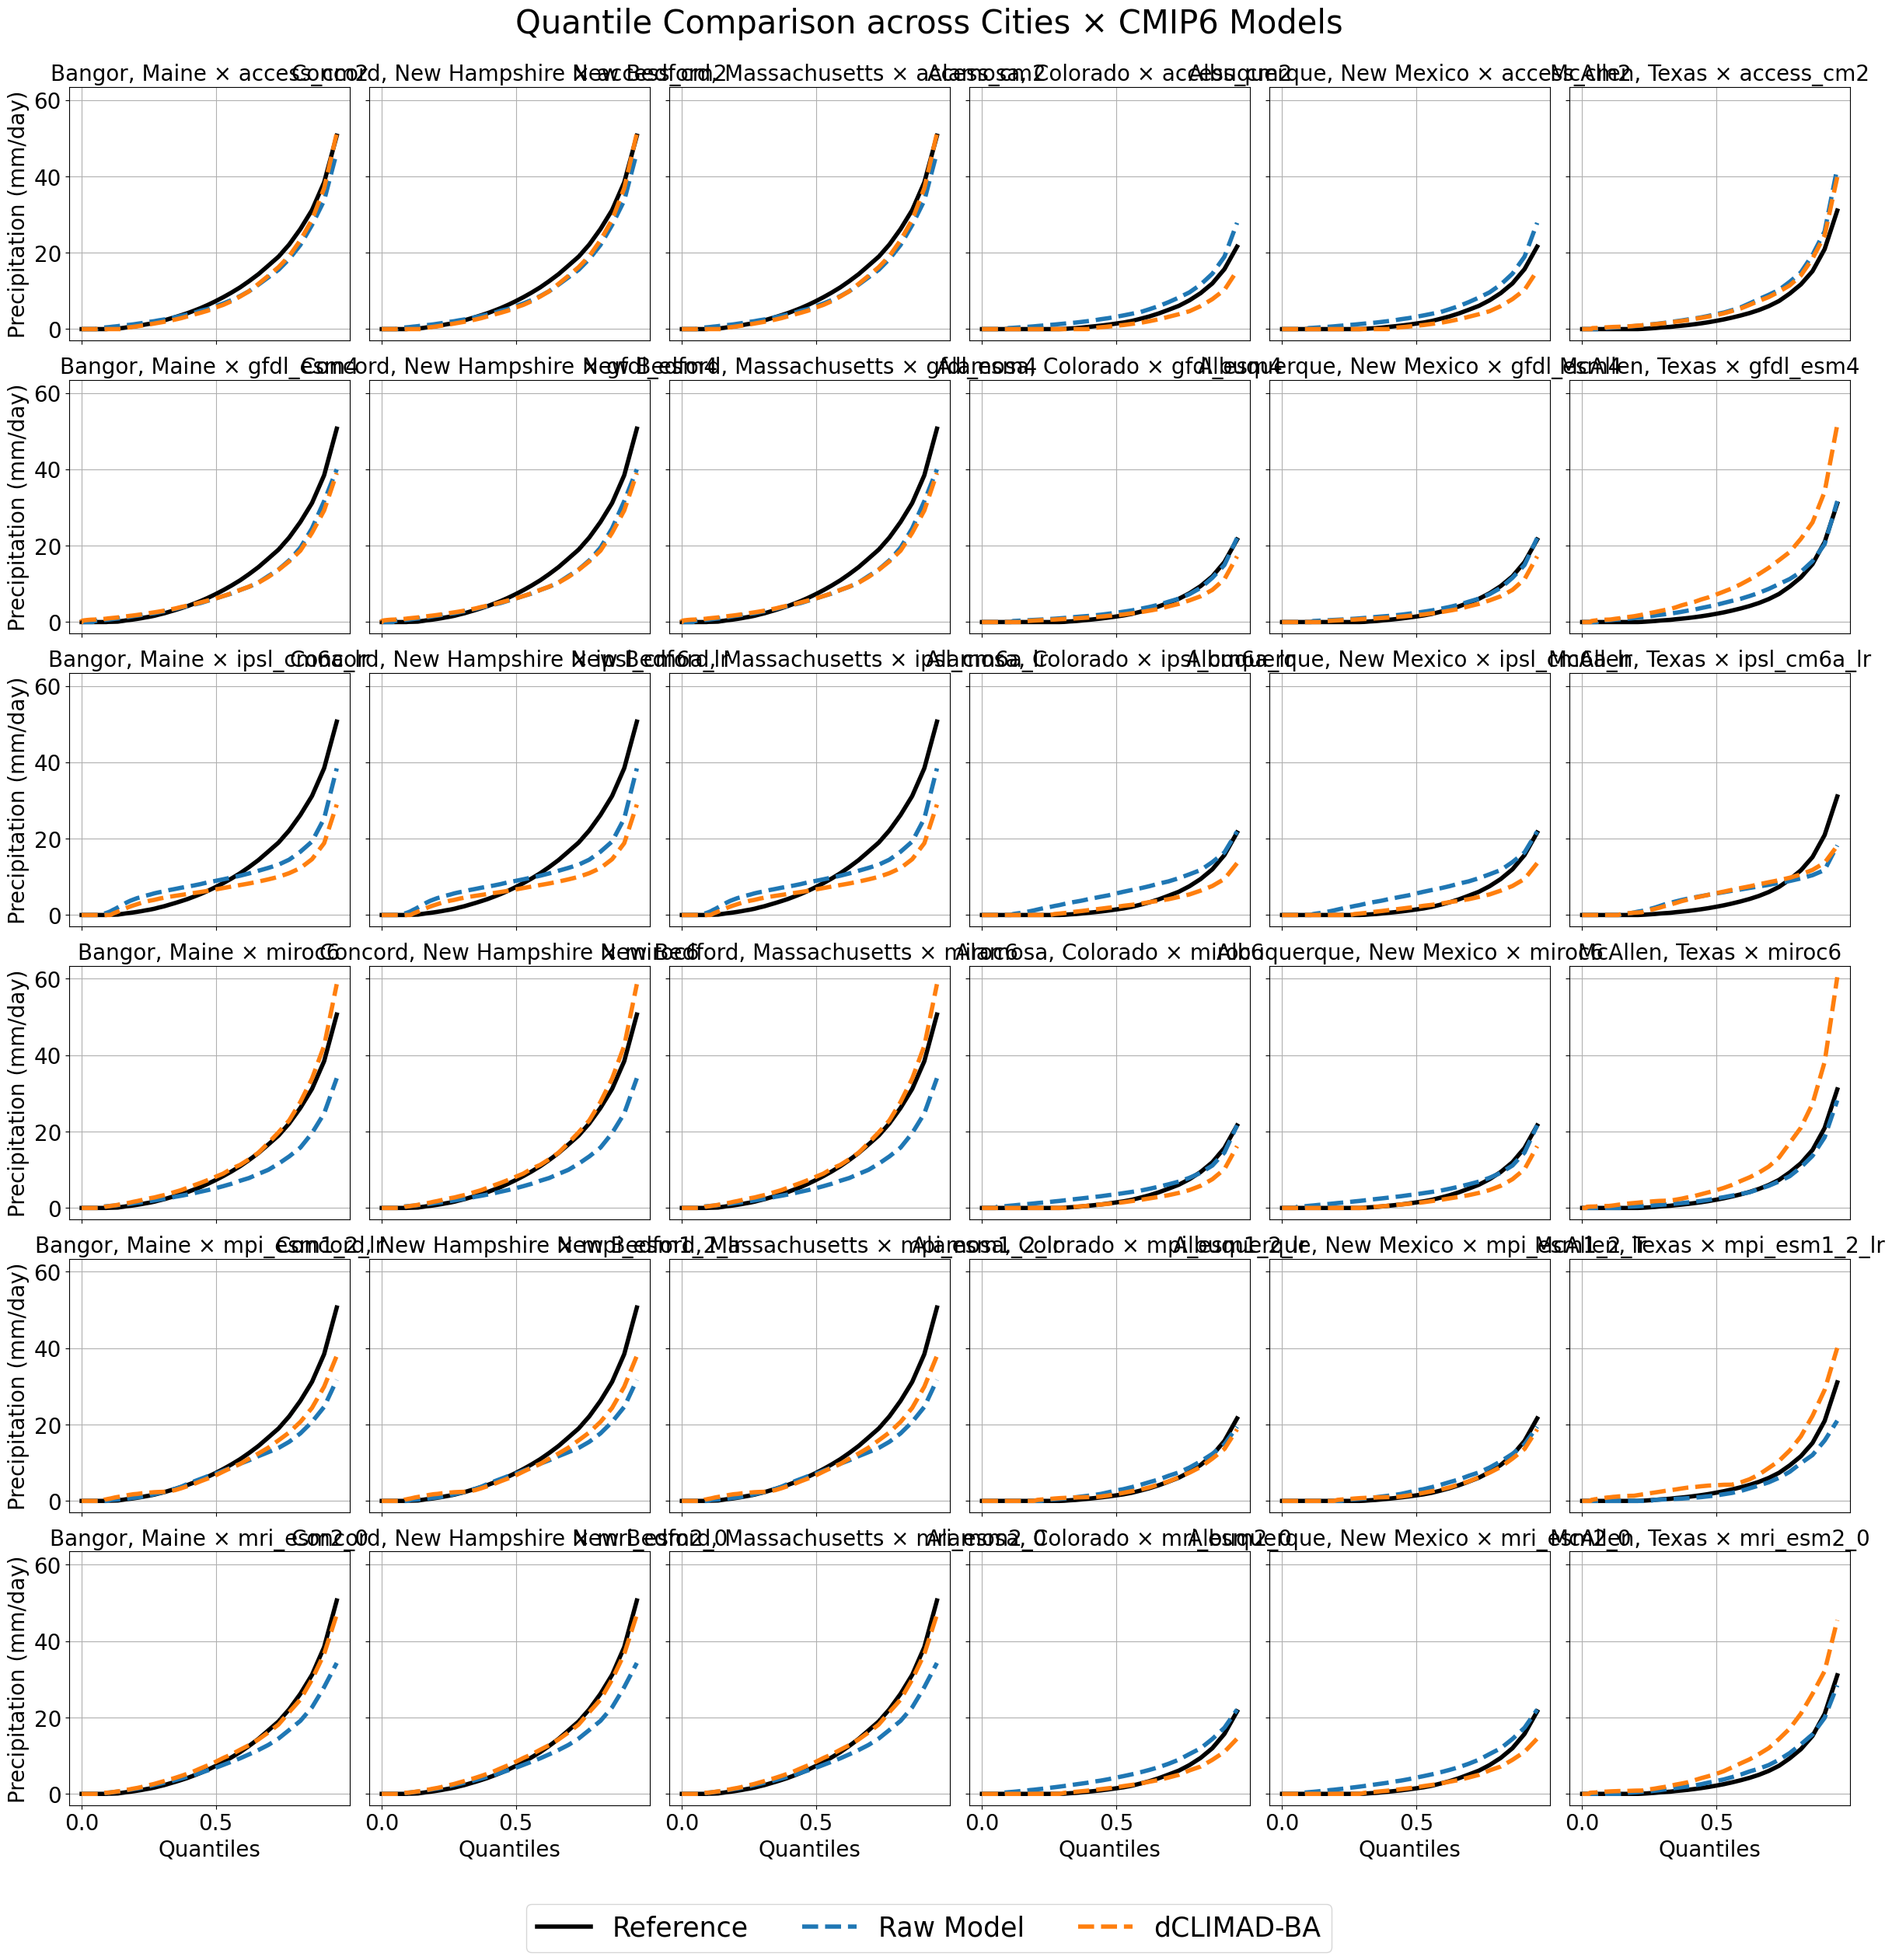

In [34]:
# Number of CMIP6 models = second dimension of quantile_x_local[i]
n_models = quantile_x_local[0].shape[1]

fig, axes = plt.subplots(
    ncols=n_cities, nrows=n_models,
    figsize=(4*n_cities, 4*n_models),
    sharex=True, sharey=True
)

if n_cities == 1 and n_models == 1:
    axes = [[axes]]
elif n_cities == 1:
    axes = [axes]
elif n_models == 1:
    axes = [[ax] for ax in axes]

for i, city in enumerate(city_names):
    for m in range(n_models):
        ax = axes[m][i]

        # Observed curve
        ax.plot(
            quantiles**5,
            quantile_y_local[i].mean(axis=1),
            color="black", linewidth=4, label="Reference"
        )

        # Raw model curve
        ax.plot(
            quantiles**5,
            quantile_x_local[i][:, m],
            linestyle="--", linewidth=4, label="Raw Model"
        )

        ax.plot(
            quantiles**5,
            quantile_xt_local[i][:, m],
            linestyle="--", linewidth=4, label="dCLIMAD-BA"
        )

        # ax.plot(
        #     quantiles**5,
        #     quantile_loca_local[i][:, m],
        #     linestyle="--", linewidth=4, label="LOCA"
        # )

        # ax.plot(
        #     quantiles**5,
        #     quantile_QM_local[i][:, m],
        #     linestyle="--", linewidth=4, label="Quantile Mapping"
        # )

        # ax.plot(
        #     quantiles**5,
        #     quantile_ISIMIP_local[i][:, m],
        #     linestyle="--", linewidth=4, label="ISIMIP"
        # )

        # ax.plot(
        #     quantiles**5,
        #     quantile_ECDFM_local[i][:, m],
        #     linestyle="--", linewidth=4, label="ECDFM"
        # )

        # ax.plot(
        #     quantiles**5,
        #     quantile_LS_local[i][:, m],
        #     linestyle="--", linewidth=4, label="Linear Scaling"
        # )

        # ax.plot(
        #     quantiles**5,
        #     quantile_QDM_local[i][:, m],
        #     linestyle="--", linewidth=4, label="Quantile Delta Mapping"
        # )

        # ax.plot(
        #     quantiles**5,
        #     quantile_SDM_local[i][:, m],
        #     linestyle="--", linewidth=4, label="Scaled Distribution Mapping"
        # )

        ax.set_title(f"{city} × {cmip6_models[m]}", fontsize=20)
        if m == n_cities - 1:
            ax.set_xlabel("Quantiles", fontsize=20)
        if i == 0:
            ax.set_ylabel("Precipitation (mm/day)", fontsize=20)
        ax.grid(True)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        # ax.set_yscale('log')
        # ax.set_xscale('log')



# Global legend
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center", ncol=5,
    bbox_to_anchor=(0.5, -0.05), fontsize=25
)

fig.suptitle("Quantile Comparison across Cities × CMIP6 Models", fontsize=30, y=1)
plt.tight_layout()
plt.savefig(f'{save_path}/Quantile_Cities_x_CMIP6_Models.png', bbox_inches='tight', dpi=300)
plt.show()
